In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
csv_file_path = r"C:\study material\CS F266\combined_data_final_for_model_100scen.csv"
df = pd.read_csv(csv_file_path)
print(df)


                   Timestamp  D_node-1  D_node-2  D_node-3  D_node-4  \
0        2017-01-01 00:00:00   -3337.2     151.2     140.4      21.6   
1        2017-01-01 00:30:00   -2973.6     136.8     122.4      18.0   
2        2017-01-01 01:00:00   -2584.8     118.8     100.8      18.0   
3        2017-01-01 01:30:00   -2419.2     108.0      93.6      14.4   
4        2017-01-01 02:00:00   -2196.0     100.8      82.8      14.4   
...                      ...       ...       ...       ...       ...   
1751995  2017-12-31 21:30:00   -5533.2     273.6     252.0      32.4   
1751996  2017-12-31 22:00:00   -5317.2     284.4     212.4      28.8   
1751997  2017-12-31 22:30:00   -4888.8     244.8     223.2      28.8   
1751998  2017-12-31 23:00:00   -4482.0     226.8     180.0      28.8   
1751999  2017-12-31 23:30:00   -4050.0     226.8     183.6      25.2   

         D_node-5  D_node-6  D_node-7  D_node-8  D_node-9  ...  Leak_node-23  \
0           104.4     169.2     219.6      86.4      90

In [14]:
df.columns

Index(['Timestamp', 'D_node-1', 'D_node-2', 'D_node-3', 'D_node-4', 'D_node-5',
       'D_node-6', 'D_node-7', 'D_node-8', 'D_node-9',
       ...
       'Leak_node-23', 'Leak_node-24', 'Leak_node-25', 'Leak_node-26',
       'Leak_node-27', 'Leak_node-28', 'Leak_node-29', 'Leak_node-30',
       'Leak_node-31', 'Leak_node-32'],
      dtype='object', length=131)

In [15]:
# Check if any value in each row of Leak_node-x columns is non-zero
leak_indicator = (df.filter(like='Leak_node-') != 0).any(axis=1)
df['Leak'] = leak_indicator.astype(int)

In [16]:
# Define leak columns and features (X) and target (y)
leak_columns = df.filter(like='Leak_node-').columns
X = df.drop(columns=['Timestamp', *leak_columns, 'Leak'])
y = df['Leak']

In [17]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = np.expand_dims(X_scaled, axis=2)

In [18]:
# Split data into training (60%), cross-validation (20%), and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_cv, y_cv), verbose=0)


In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10950/10950 [==============================] - 246s 22ms/step - loss: 0.0021 - accuracy: 0.9993
Test Loss: 0.002071778755635023
Test Accuracy: 0.9992865324020386


10950/10950 [==============================] - 57s 5ms/step


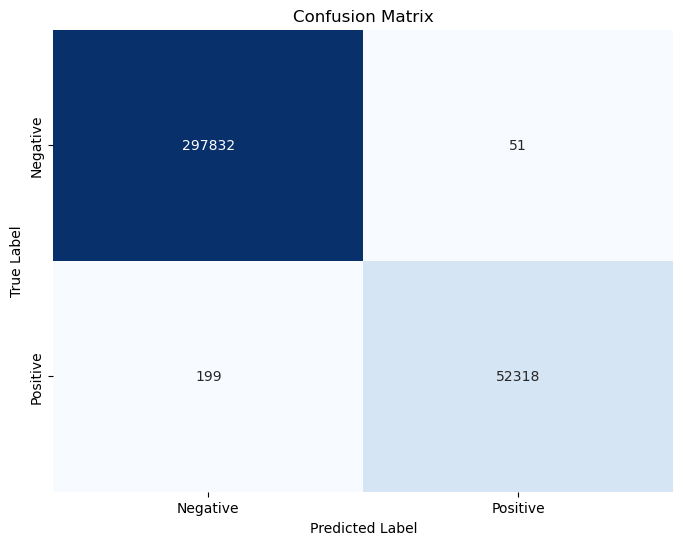

In [23]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

10950/10950 [==============================] - 69s 6ms/step


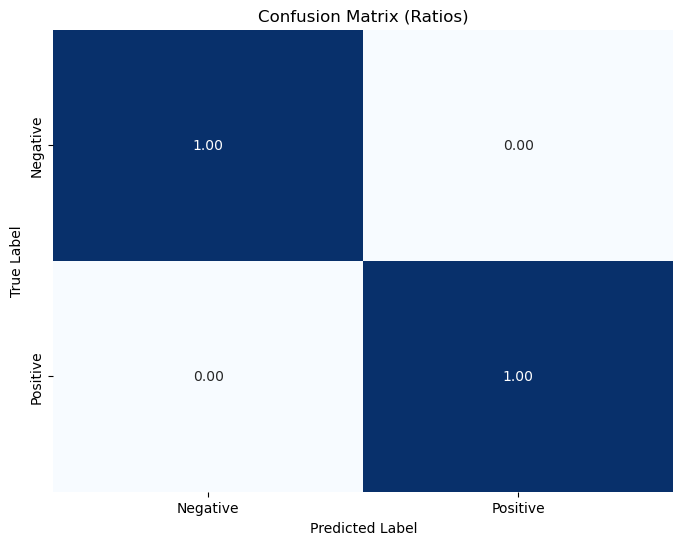

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate ratios
conf_matrix_ratios = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ratios, annot=True, fmt=".2f", cmap="Blues", cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Ratios)')
plt.show()


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", roc_auc)


Accuracy: 0.9992865296803652
Precision: 0.999026141419542
Recall: 0.9962107508045014
ROC AUC Score: 0.9999938932191692


In [25]:
from sklearn.model_selection import train_test_split, KFold
# Define the number of folds for cross-validation
n_splits = 5

# Initialize lists to store training and validation errors for each fold
train_errors = []
val_errors = []

# Initialize KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True)

# Loop through each fold
for train_index, val_index in kf.split(X_reshaped):
    # Split the data into training and validation sets for this fold
    X_train, X_val = X_reshaped[train_index], X_reshaped[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train the model and record training/validation errors for each epoch
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    
    # Append training and validation errors to the lists
    train_errors.append(history.history['loss'])
    val_errors.append(history.history['val_loss'])

# Calculate average training and validation errors across all folds
avg_train_errors = np.mean(train_errors, axis=0)
avg_val_errors = np.mean(val_errors, axis=0)

# Plot epochs vs cross-validation error curve
plt.plot(range(1, len(avg_train_errors) + 1), avg_train_errors, label='Training Error')
plt.plot(range(1, len(avg_val_errors) + 1), avg_val_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Epochs vs Cross-Validation Error')
plt.legend()
plt.show()

KeyboardInterrupt: 